In [6]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [7]:
mnist = tf.keras.datasets.mnist

(x_train,y_train), (x_test,y_test) = mnist.load_data()

x_train,x_test = x_train/255.0 *2 -1, x_test / 255.0 * 2 -1 

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
N,H,W = x_train.shape
D=H*W
x_train = x_train.reshape(-1,D)
x_trst = x_test.reshape(-1,D)


In [10]:
latent_dim = 100

In [11]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D,activation='tanh')(x)

  model = Model(i,x)

  return model

In [12]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512,activation = LeakyReLU(alpha=0.2))(i)
  x = Dense(256,activation = LeakyReLU(alpha=0.2))(x)
  x = Dense(1,activation ='sigmoid')(x)
  model = Model(i,x)
  return model 


In [17]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer = Adam(0.0002,0.5),
    metrics=['accuracy']
)

generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))

img = generator(z)

discriminator.trainable=False


fake_pred=discriminator(img)

combined_model=Model(z,fake_pred)

combined_model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))

In [14]:
batch_size=32
epochs=30000
sample_period=200

In [15]:
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

d_losses=[]
g_losses=[]

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

  

In [19]:
def sample_images(epoch):
  rows, cols=5,5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  imgs=0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows,cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()



In [ ]:
for epoch in range(epochs):
  idx = np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs=x_train[idx]

  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=generator.predict(noise)


  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  noise = np.random.randn(batch_size,latent_dim)
  g_loss = combined_model.train_on_batch(noise,ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/30000, d_loss: 0.34, d_acc: 0.91, g_loss: 0.81
epoch: 101/30000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.11
epoch: 201/30000, d_loss: 0.03, d_acc: 0.98, g_loss: 5.26
epoch: 301/30000, d_loss: 0.07, d_acc: 0.98, g_loss: 4.44
epoch: 401/30000, d_loss: 0.76, d_acc: 0.55, g_loss: 1.24
epoch: 501/30000, d_loss: 0.63, d_acc: 0.52, g_loss: 0.78
epoch: 601/30000, d_loss: 0.68, d_acc: 0.47, g_loss: 0.82
epoch: 701/30000, d_loss: 0.59, d_acc: 0.75, g_loss: 0.83
epoch: 801/30000, d_loss: 0.64, d_acc: 0.66, g_loss: 0.75
epoch: 901/30000, d_loss: 0.65, d_acc: 0.64, g_loss: 0.86
epoch: 1001/30000, d_loss: 0.58, d_acc: 0.73, g_loss: 0.88
epoch: 1101/30000, d_loss: 0.61, d_acc: 0.64, g_loss: 0.79
epoch: 1201/30000, d_loss: 0.55, d_acc: 0.70, g_loss: 0.91
epoch: 1301/30000, d_loss: 0.58, d_acc: 0.67, g_loss: 0.99
epoch: 1401/30000, d_loss: 0.59, d_acc: 0.72, g_loss: 0.90
epoch: 1501/30000, d_loss: 0.53, d_acc: 0.77, g_loss: 0.99
epoch: 1601/30000, d_loss: 0.60, d_acc: 0.75, g_loss: 0.98
epoch: 17

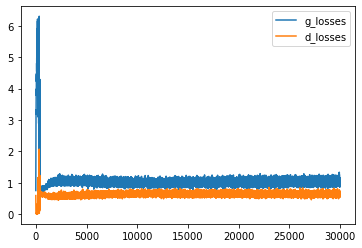

In [21]:
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')
plt.legend()

In [22]:
!zip -r gan_imagesz.zip gan_images

  adding: gan_images/ (stored 0%)
  adding: gan_images/10400.png (deflated 7%)
  adding: gan_images/14600.png (deflated 7%)
  adding: gan_images/12200.png (deflated 7%)
  adding: gan_images/18000.png (deflated 8%)
  adding: gan_images/29600.png (deflated 8%)
  adding: gan_images/28600.png (deflated 8%)
  adding: gan_images/24200.png (deflated 8%)
  adding: gan_images/9800.png (deflated 8%)
  adding: gan_images/29800.png (deflated 8%)
  adding: gan_images/4600.png (deflated 6%)
  adding: gan_images/24400.png (deflated 8%)
  adding: gan_images/0.png (deflated 11%)
  adding: gan_images/15800.png (deflated 8%)
  adding: gan_images/1800.png (deflated 8%)
  adding: gan_images/14800.png (deflated 8%)
  adding: gan_images/14200.png (deflated 8%)
  adding: gan_images/21000.png (deflated 8%)
  adding: gan_images/22000.png (deflated 8%)
  adding: gan_images/13400.png (deflated 8%)
  adding: gan_images/24000.png (deflated 8%)
  adding: gan_images/13000.png (deflated 8%)
  adding: gan_images/8000.p